In [76]:
import sys
from pathlib import Path
from addict import Dict as Adict
import pandas as pd
import seaborn as sns
import mdtraj as md
from natsort import natsorted

sys.path.insert(0, '/home/rzhu/Desktop/projects/kinase_analysis/src/')
from funcs_featurise import *
from funcs_db_assign import *
from funcs_indices import *
from funcs_plotting import *
from funcs_sample import *
from TrajData import TrajData
from MSMStudy import MSMStudy

plt.rcParams['xtick.labelsize'] = 14  # Font size for x-tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y-tick labels
plt.rcParams['legend.fontsize'] = 16  # Font size for legend
plt.rcParams['axes.labelsize'] = 18   # Font size for x-label and y-label
plt.rcParams['axes.titlesize'] = 18   # Font size for title

In [77]:
protein = 'abl'
key = 'abl-pdb-50ps' # Dataset key 
study = 'with_prior' # where the results are saved
data_path = Path(f'/home/rzhu/Desktop/projects/kinase_analysis/data') # base dir

hps_df = pd.read_csv(data_path/f'{protein}'/'msm'/f'{study}'/'hps.csv')
TD = TrajData(protein = protein)
TD.add_dataset(rtraj_dir = Path(f'/arc/abl_processed/'), 
               ftraj_dir= data_path / f'{protein}'/ f'{key}' / 'ftrajs',
               dt=0.05,
               key=key)
study = MSMStudy(hps_table = hps_df,
                 traj_data = TD,
                 wk_dir = data_path/f'{protein}'/'msm'/f'{study}')
study.observation

Setting dataset <abl-pdb-50ps>. 
Number of raw trajectories: 749



,hp_id,time_consumed,is_sparse,ev_1,ev_2,ev_3,ev_4,ev_5,ev_6,ev_7,...,vamp2_std_2,vamp2_std_3,vamp2_std_4,vamp2_std_5,vamp2_std_6,vamp2_std_7,vamp2_std_8,vamp2_std_9,vamp2_std_10,vamp2_std_11
0,1,1074.410517,False,1.0,0.999890,0.999787,0.999782,0.999431,0.999369,0.997438,...,0.000140,0.000156,0.000186,0.000216,0.000257,0.000260,0.000290,0.000322,0.000335,0.003066
1,2,1013.094291,False,1.0,0.999886,0.999787,0.999762,0.999428,0.999368,0.997492,...,0.000135,0.000173,0.000192,0.000191,0.000224,0.000230,0.000256,0.000274,0.000279,0.003603
2,3,1017.254637,False,1.0,0.999891,0.999773,0.999725,0.999414,0.999363,0.997478,...,0.000178,0.000186,0.000219,0.000225,0.000256,0.000261,0.000279,0.000296,0.000310,0.000672
3,4,984.530003,False,1.0,0.999879,0.999758,0.999714,0.999405,0.999334,0.997464,...,0.000121,0.000171,0.000287,0.000222,0.000255,0.000262,0.000287,0.000306,0.000309,0.001657
4,5,3786.938161,False,1.0,0.999802,0.999065,0.998065,0.997963,0.997724,0.997167,...,0.000023,0.000032,0.000200,0.000305,0.000257,0.000259,0.000303,0.000339,0.000356,0.000374


In [78]:
study.set_hp_id(4)

Set dataset abl-pdb-50ps stride to 1
Loading MSM model id 4 from /home/rzhu/Desktop/projects/kinase_analysis/data/abl/msm/with_prior/4
{'hp_id': 4, 'datasets': 'abl-pdb-50ps', 'features': 'dbdist dbdihed achelix aloop', 'dt_out': 0.05, 'time_cutoff': 100, 'tica_lag_time': 1, 'tica_stride': 1000, 'tica_dim': 20, 'tica_kinetic_map': True, 'cluster_n': 1000, 'cluster_stride': 1000, 'cluster_max_iter': 1000, 'seed': 42, 'markov_lag_time': 100, 'markov_count_mode': 'effective', 'markov_count_prior': True, 'msm_mode': 'bayesian'}
Loading trajectories...
Loading models...
Done


In [79]:
study.run_pcca(6)

In [80]:
traj_all = study.ttraj_cat
dim_1 = 0
dim_2 = 1
traj_weights = np.concatenate(study.traj_weights, axis=0)
fes_cmap = 'nipy_spectral'
n_states = 6
c_centers = study.kmeans_centers[study.connected_states, :]
pcca_assignment = study.pcca_mod.assignments
stat_dist = study.msm_mod.stationary_distribution

In [81]:
macrostate_centroid = []
for i in range(n_states):
    macrostate_cluster_centers = c_centers[pcca_assignment == i, :]
    macrostate_cluster_weights = stat_dist[pcca_assignment == i]
    weighted_centroid = np.average(macrostate_cluster_centers, axis=0, weights=macrostate_cluster_weights)
    macrostate_centroid.append(weighted_centroid)
pos = {i:(macrostate_centroid[i][dim_1], macrostate_centroid[i][dim_2]) for i in range(n_states)}

In [82]:
cg_stationary_dist = [sum(stat_dist[pcca_assignment == i]) for i in range(n_states)]
node_sizes = cg_stationary_dist/min(cg_stationary_dist)*100
node_ln_widths = np.cbrt(node_sizes/min(node_sizes))
node_ft_sizes = np.cbrt(node_sizes/min(node_sizes))*8

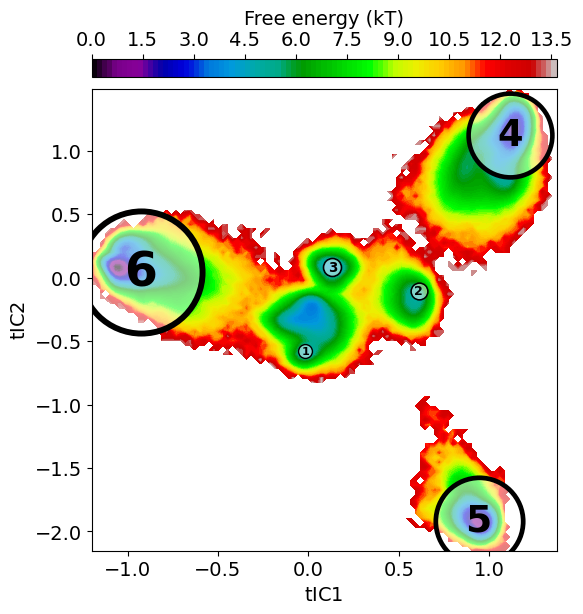

In [ ]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(6, 6))

# Plot the energy surface
ax, contour, cbar = plot_energy2d(
    energy2d(traj_all[:, dim_1], traj_all[:, dim_2], weights=traj_weights),
    ax=ax,
    contourf_kws=dict(cmap=fes_cmap),
    cbar=False  # Horizontal colorbar
)

# Get the position of the main plot
ax_pos = ax.get_position()

# Create a new colorbar axis aligned with the main plot
cbar_height = 0.03  # Height of the colorbar
cbar_ax = fig.add_axes([ax_pos.x0, ax_pos.y1 + 0.02, ax_pos.width, cbar_height])  # [left, bottom, width, height]

cbar = fig.colorbar(contour, cax=cbar_ax, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.set_xlabel(r'Free energy (kT)', fontsize=14)

for i, (n, (x, y)) in enumerate(pos.items()):
    ax.scatter(
        x, y, 
        s=node_sizes[n], 
        facecolors=(1, 1, 1, 0.5),
        edgecolors='black', 
        linewidths=node_ln_widths[n]
    )
    ax.text(
        x, y, 
        str(n+1),  # Label inside the circle
        fontsize=node_ft_sizes[n], 
        ha='center', va='center', 
        fontweight='bold'
    )

# legend_handles = []
# for n in pos:
#     circle_patch = mpatches.Circle(
#         (0, 0), 1,  # Placeholder location and size
#         edgecolor='black',
#         label=f'Node {n}'  # Custom label text for the legend
#     )
#     legend_handles.append(circle_patch)
# ax.legend(handles=legend_handles)


# Set axis labels
ax.set_xlabel(fr'$\mathrm{{tIC}}{dim_1+1}$', fontsize=14)
ax.set_ylabel(fr'$\mathrm{{tIC}}{dim_2+1}$', fontsize=14)

plt.savefig('fig2a_abl.pdf', bbox_inches='tight')
plt.show()

In [93]:
# Load the precomputed Dunbrack states assignment 
# hdbscan_dist_group / hdbscan_dihed_group -- used hdbscan
# distgroup / dihedgroup -- used average-linkage hierachical clustering 

TD.load_ftrajs(key=key,
               feature_names=['hdbscan_dist_group', 'hdbscan_dihed_group'],)
distgroup, _ = TD.get_ftrajs(keys=key, 
                             dt_out=0.05, 
                             internal_names=['hdbscan_dist_group'], 
                             time_cutoff=0,
                             convert_dihed_ids=None)
dihedgroup, _ = TD.get_ftrajs(keys=key, 
                              dt_out=0.05, 
                              internal_names=['hdbscan_dihed_group'], 
                              time_cutoff=0,
                              convert_dihed_ids=None)
distgroup_cat = np.concatenate(distgroup).flatten()
dihedgroup_cat = np.concatenate(dihedgroup).flatten()

sim_ptraj_cat = np.array([study.micro_to_macro[d] if d in study.connected_states else -1 for d in study.dtraj_cat])

abl-pdb-50ps
Loading feature:  hdbscan_dist_group


100%|██████████| 749/749 [00:00<00:00, 13549.68it/s]


Loading feature:  hdbscan_dihed_group


100%|██████████| 749/749 [00:00<00:00, 12371.65it/s]


Stride for dataset abl-pdb-50ps with timestep 0.05 ns: 1
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 89811.99it/s]


Stride for dataset abl-pdb-50ps with timestep 0.05 ns: 1
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 52809.54it/s]


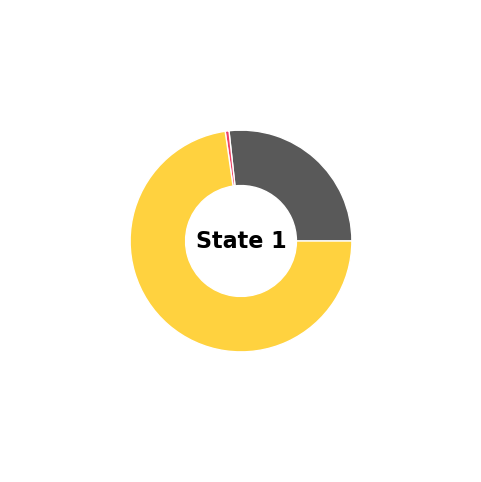

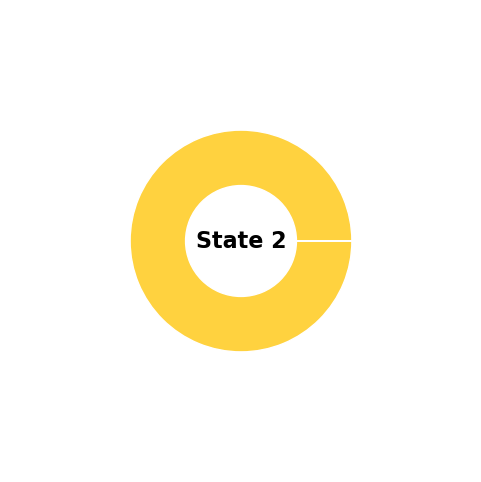

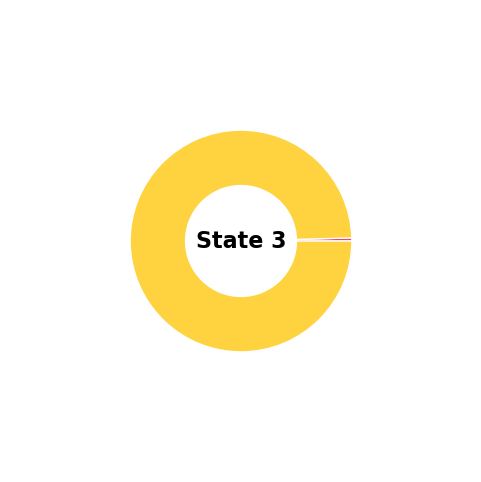

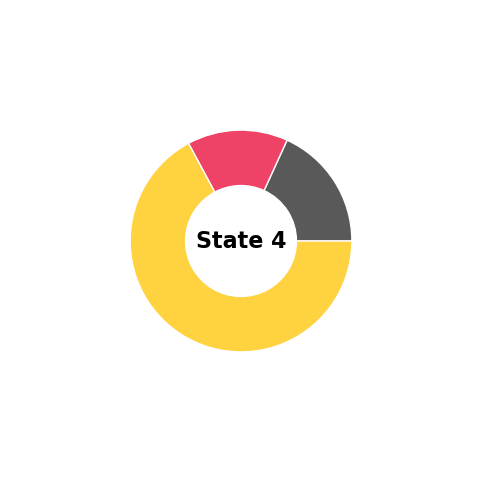

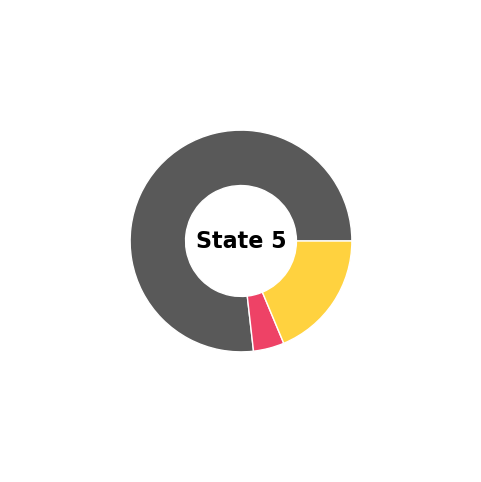

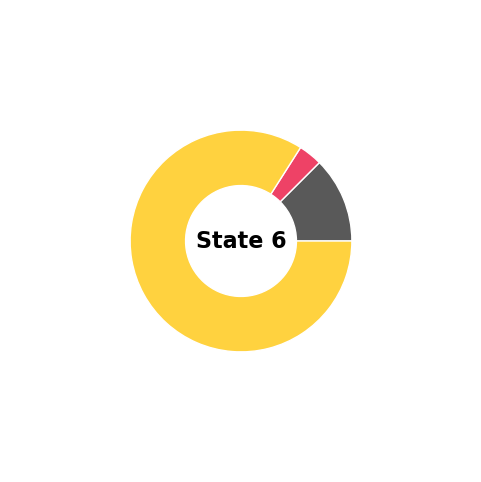

In [106]:
for state_i in range(study.pcca_n):
    frame_indices = np.where(sim_ptraj_cat == state_i)[0]
    spatial_assignments, dihed_assignments = distgroup_cat[frame_indices], dihedgroup_cat[frame_indices]
    
    spatial_counts, dihed_counts = dunbrack_count(spatial_assignments, dihed_assignments)
    plot_dihed_pie(spatial_counts, dihed_counts, 
                   radius_size=0.3, show_legend=False, show_dihed=False,
                   title=f'State {state_i+1}', 
                   savedir=study.fig_dir/f'state_{state_i+1}_dihed.pdf')

In [ ]:
def plot_dihed_pie(spatial_counts, dihed_counts, 
                   show_legend=False, show_dihed='all', radius_size=0.5, 
                   figsize=(6,6), title='', fontsize=12, savedir=None):
    
    spatial_cluster_labels = ['noise', 'DFG-in', 'DFG-inter', 'DFG-out']
    dihed_cluster_labels = ['noise', 
                            'noise', 'BLAminus', 'BLAplus', 'ABAminus', 'BLBminus', 'BLBplus', 'BLBtrans', 
                            'noise', 'BABtrans', 
                            'noise', 'BBAminus']
    
    inner_colors = dfg_spatial_colors
    outer_colors = [dfg_dihed_colors[0],     # white for undefined spatial group
                    dfg_dihed_colors[0], *dfg_dihed_colors[1:7],  # DFG-in sub-clusters
                    dfg_dihed_colors[0], dfg_dihed_colors[7],  # DFG-inter sub-clusters
                    dfg_dihed_colors[0], dfg_dihed_colors[8]]  # DFG-out sub-clusters
    
    filtered_spatial_cluster_labels = [label if count/sum(spatial_counts) >= 0.05 else '' for label, count in zip(spatial_cluster_labels, spatial_counts)]
    filtered_dihed_cluster_labels = [label if count/sum(sum(dihed_counts,[])) >= 0.05 else '' for label, count in zip(dihed_cluster_labels, sum(dihed_counts,[]))]

    fig, ax = plt.subplots(figsize=figsize)
 

    if show_dihed == 'all':
        wedges_i, texts_i = ax.pie(spatial_counts, radius=1-radius_size, 
                                colors=inner_colors, 
                                wedgeprops=dict(width=radius_size, edgecolor='w'))        
        wedges_o, texts_o = ax.pie(sum(dihed_counts,[]), radius=1, 
                                   colors=outer_colors,
                                   labels=filtered_dihed_cluster_labels, 
                                   textprops={'fontsize': fontsize, 'fontweight': 'bold'}, 
                                   labeldistance=0.7,
                                   wedgeprops=dict(width=radius_size, edgecolor='w'))
    elif show_dihed == 'no_labels':
        wedges_i, texts_i = ax.pie(spatial_counts, radius=1-radius_size, 
                        colors=inner_colors, 
                        wedgeprops=dict(width=radius_size, edgecolor='w'))   
        wedges_o, texts_o = ax.pie(sum(dihed_counts,[]), radius=1, 
                                   colors=outer_colors,
                                   wedgeprops=dict(width=radius_size, edgecolor='w'))
    else:
        wedges_i, texts_i = ax.pie(spatial_counts, radius=0.6, 
                                colors=inner_colors, 
                                wedgeprops=dict(width=radius_size, edgecolor='w'))
        
    ax.set(aspect="equal")
    ax.text(0, 0, title, ha='center', va='center', fontsize=16, fontweight='bold')

    if show_legend:
        ax.legend(wedges_i, spatial_cluster_labels,
                loc="center left",
                bbox_to_anchor=(1, 0, 0.5, 1),
                fontsize=18,
                markerscale=2)
    
    if savedir is not None:
        plt.savefig(savedir, transparent=True, bbox_inches='tight', dpi=300)
    plt.show()

    return None 